In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import optuna

import lazypredict
from lazypredict.Supervised import LazyRegressor

import statsmodels.api as sm

/home/elisio/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# [Air Quality Data Set](https://archive.ics.uci.edu/ml/datasets/Air+Quality)
[Data set download link]('https://archive.ics.uci.edu/ml/machine-learning-databases/00360/')
#### Data Set Information:

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value.
This dataset can be used exclusively for research purposes. Commercial purposes are fully excluded.

#### Data Set description:

- 0 Date (DD/MM/YYYY)
- 1 Time (HH.MM.SS)
- 2 True hourly averaged concentration CO in mg/m^3 (reference analyzer)
- 3 PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted)
- 4 True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer)
- 5 True hourly averaged Benzene concentration in microg/m^3 (reference analyzer)
- 6 PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted)
- 7 True hourly averaged NOx concentration in ppb (reference analyzer)
- 8 PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted)
- 9 True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)
- 10 PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted)
- 11 PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted)
- 12 Temperature in Â°C
- 13 Relative Humidity (%)
- 14 AH Absolute Humidity

#### Analysis

The variable that will be predicted is PT08.S1(CO), which is the concentration of CO.  

### Dataset overview

In [2]:
# Load the data set
df = pd.read_excel('data/AirQualityUCI.xlsx')#, parse_dates=[['Date', 'Time']])
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.60,1360.00,150,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,48.88,0.76
1,2004-03-10,19:00:00,2.00,1292.25,112,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,47.70,0.73
2,2004-03-10,20:00:00,2.20,1402.00,88,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,53.98,0.75
3,2004-03-10,21:00:00,2.20,1375.50,80,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,60.00,0.79
4,2004-03-10,22:00:00,1.60,1272.25,51,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,59.58,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.10,1314.25,-200,13.53,1101.25,471.70,538.50,189.80,1374.25,1728.50,21.85,29.25,0.76
9353,2005-04-04,11:00:00,2.40,1162.50,-200,11.36,1027.00,353.30,603.75,179.20,1263.50,1269.00,24.33,23.72,0.71
9354,2005-04-04,12:00:00,2.40,1142.00,-200,12.37,1062.50,293.00,603.25,174.70,1240.75,1092.00,26.90,18.35,0.64
9355,2005-04-04,13:00:00,2.10,1002.50,-200,9.55,960.50,234.50,701.50,155.70,1041.00,769.75,28.32,13.55,0.51


In [3]:
# Display the types of each column
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                  int64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

array([[<AxesSubplot:title={'center':'AH'}>,
        <AxesSubplot:title={'center':'C6H6(GT)'}>,
        <AxesSubplot:title={'center':'CO(GT)'}>,
        <AxesSubplot:title={'center':'NMHC(GT)'}>],
       [<AxesSubplot:title={'center':'NO2(GT)'}>,
        <AxesSubplot:title={'center':'NOx(GT)'}>,
        <AxesSubplot:title={'center':'PT08.S1(CO)'}>,
        <AxesSubplot:title={'center':'PT08.S2(NMHC)'}>],
       [<AxesSubplot:title={'center':'PT08.S3(NOx)'}>,
        <AxesSubplot:title={'center':'PT08.S4(NO2)'}>,
        <AxesSubplot:title={'center':'PT08.S5(O3)'}>,
        <AxesSubplot:title={'center':'RH'}>],
       [<AxesSubplot:title={'center':'T'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

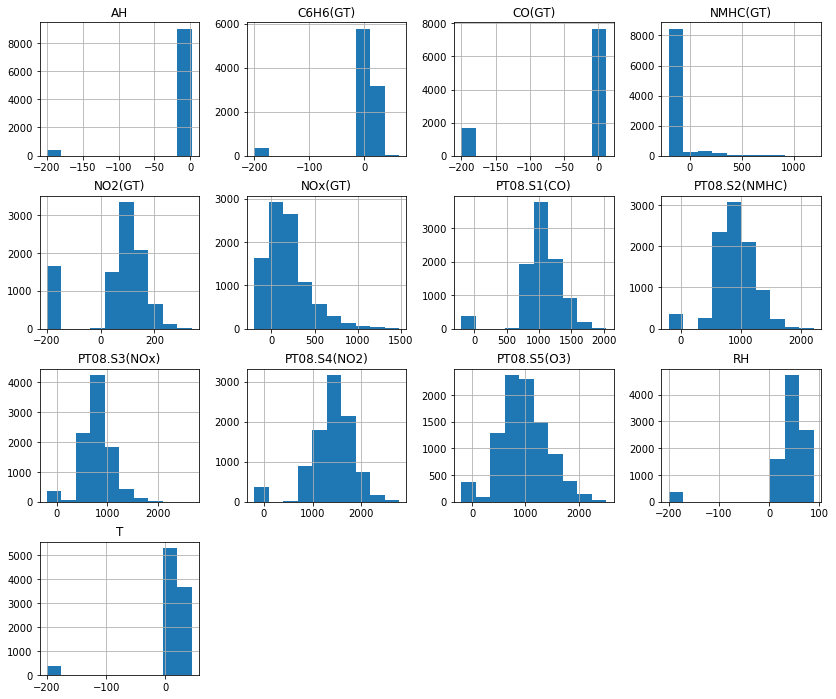

In [4]:
df.hist(figsize=(14,12))

By plotting the distributions of the dataset it's clear how the missing values (tagged with `-200.000` value) are affecting the overall dataset as it's the min for all variables.
<br>
The statistics summary below also shows this problem.

In [5]:
# Summary statistics of each column
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00,9357.00
mean,-34.21,1048.87,-159.09,1.87,894.48,168.60,794.87,58.14,1391.36,974.95,9.78,39.48,-6.84
std,77.66,329.82,139.79,41.38,342.32,257.42,321.98,126.93,467.19,456.92,43.20,51.22,38.98
min,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00,-200.00
25%,0.60,921.00,-200.00,4.00,711.00,50.00,637.00,53.00,1184.75,699.75,10.95,34.05,0.69
50%,1.50,1052.50,-200.00,7.89,894.50,141.00,794.25,96.00,1445.50,942.00,17.20,48.55,0.98
75%,2.60,1221.25,-200.00,13.64,1104.75,284.20,960.25,133.00,1662.00,1255.25,24.07,61.88,1.30
max,11.90,2039.75,1189.00,63.74,2214.00,1479.00,2682.75,339.70,2775.00,2522.75,44.60,88.73,2.23


# Exploratory Data Analysis 

### Cleaning missing data

In [6]:
# replace all -200 with NaN
df.replace(-200, np.NaN, inplace=True)

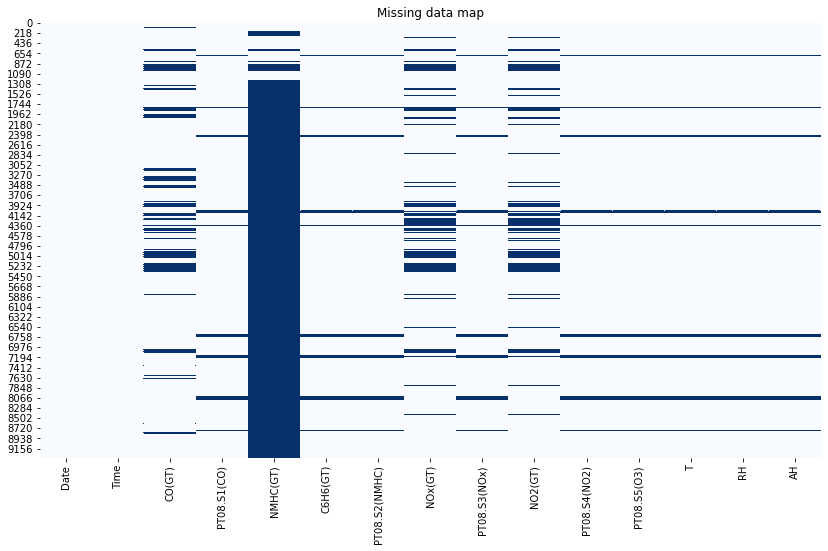

In [7]:
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Missing data map")
plt.show()

In [8]:
# Percentage of missing values per column
nan_perc = df.isna().sum()/len(df.index)*100
nan_perc

Date             0.00
Time             0.00
CO(GT)          17.99
PT08.S1(CO)      3.91
NMHC(GT)        90.23
C6H6(GT)         3.91
PT08.S2(NMHC)    3.91
NOx(GT)         17.52
PT08.S3(NOx)     3.91
NO2(GT)         17.55
PT08.S4(NO2)     3.91
PT08.S5(O3)      3.91
T                3.91
RH               3.91
AH               3.91
dtype: float64

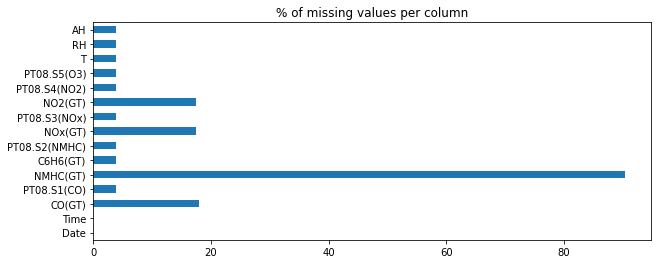

In [9]:
plt.figure(figsize=(10,4))
nan_perc.plot.barh().set_title('% of missing values per column')
plt.show()

* The concentration of missing values on variable **NMHC(GT)** is considerably high (over `90%`).
* Columns **NOx(GT)** and **NO2(GT)** seems correlatated regarding missing data.
* The columns **PT08.S1(CO)**, **C6H6(GT)**, **PT08.S2(NMHC)**, **PT08.S3(NOx)**, **PT08.S4(NO2)**, **PT08.S5(O3)**, **T**, **RH**, **AH**, are also higly correlated on their missing data patterns.   
<br><br>
Due to the high concentration of missing values in **NMHC(GT)** it makes sense to drop this column. <br>
Three other columns also display a high concentration of missing values **CO(GT), NOx(GT), NO2(GT)** of over `17%` and these missing values will be filled with the last valid observation.


In [10]:
# Drop column which is full of missing values
df.drop(columns=['NMHC(GT)'], inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.60,1360.00,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,48.88,0.76
1,2004-03-10,19:00:00,2.00,1292.25,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,47.70,0.73
2,2004-03-10,20:00:00,2.20,1402.00,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,53.98,0.75
3,2004-03-10,21:00:00,2.20,1375.50,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,60.00,0.79
4,2004-03-10,22:00:00,1.60,1272.25,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,59.58,0.79


In [11]:
# Fill missing values of all other columns
df.fillna(method='ffill', inplace=True)

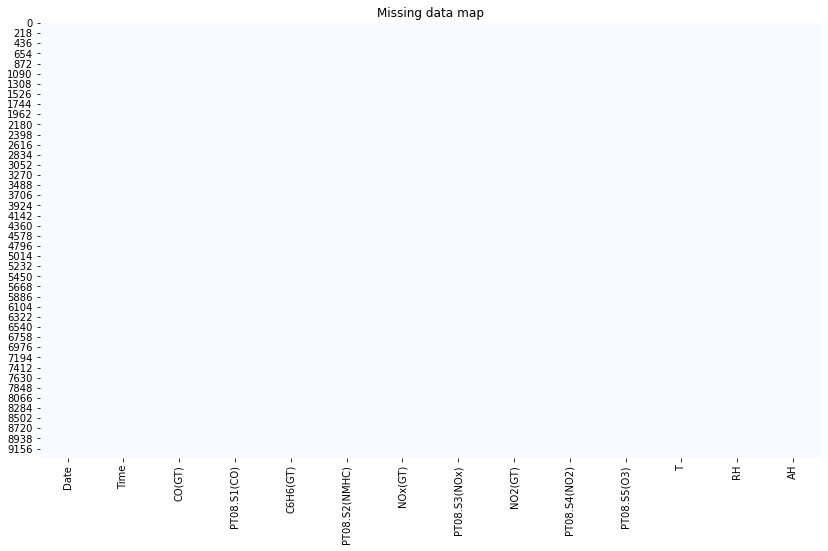

In [12]:
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Missing data map")
plt.show()

All missing values were gone!

### Dealing with outliers

[]

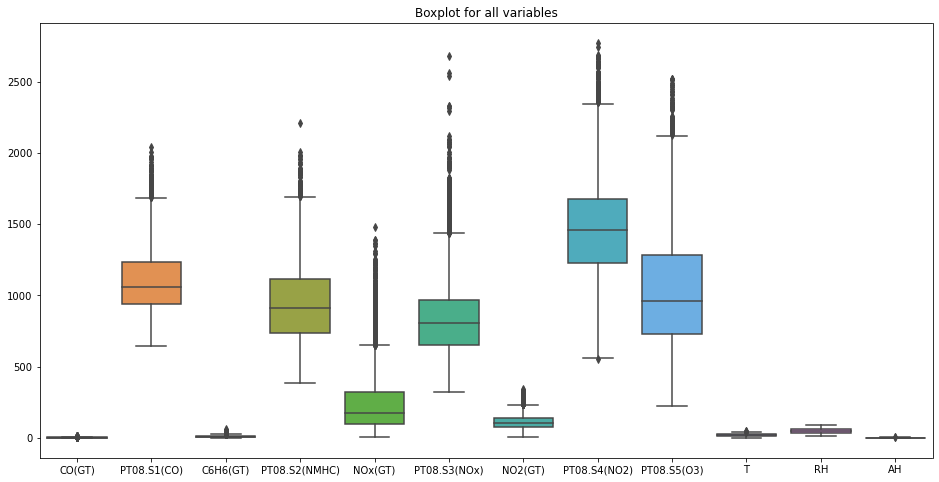

In [13]:
# showing the boxplot for all variables (except Date and Time)
plt.figure(figsize=(16,8))
sns.boxplot(data=df.loc[:, 'CO(GT)':'AH']).set_title("Boxplot for all variables")
plt.plot()

By the boxplot it's clear there're some outliers.<br>
Q1 and Q3 are the lower and upper quartiles respectively.<br>

Considering the [inner fences](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) to detect outliers:<br>
lower inner fence: Q1 - 1.5*IQ<br>
upper inner fence: Q3 + 1.5*IQ

In [14]:
# go through all the columns (starting from column CO(GT)),
# calculate the outlier's fences and mark as null each value that
# goes beyond these limitations.

for col in df.columns[2:]:
    q1 = df[col].quantile(.25)
    q3 = df[col].quantile(.75)
    
    lower_f = q1 - 1.5*q1
    upper_f = q3 + 1.5*q3
    
    df[col] = df[col].apply(lambda x: np.nan if ((x<lower_f) or (x>upper_f)) else x)

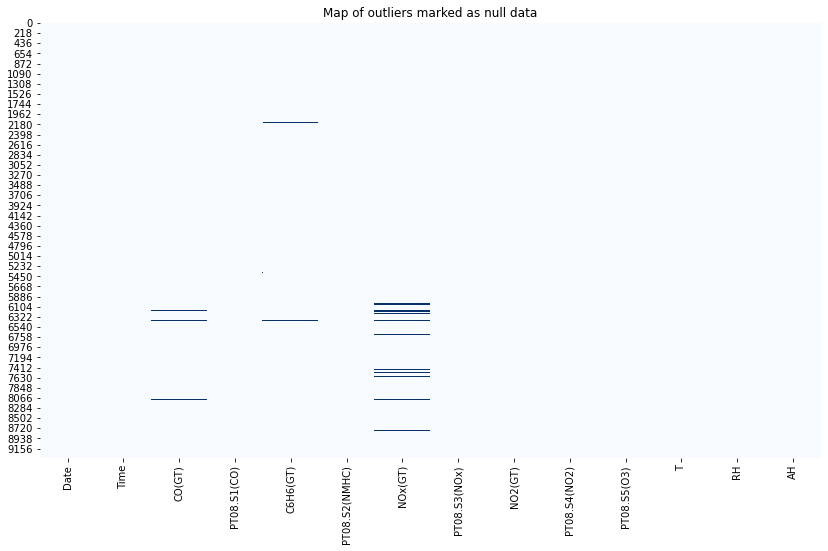

In [15]:
# plot the new map of outliers (marked as null data)
plt.figure(figsize=(14,8))
sns.heatmap(df.isna(), cbar=False, cmap="Blues").set_title("Map of outliers marked as null data")
plt.show()

In [16]:
# Percentage of missing values per column
nan_perc = df.isna().sum()/len(df.index)*100
nan_perc

Date            0.00
Time            0.00
CO(GT)          0.71
PT08.S1(CO)     0.00
C6H6(GT)        0.90
PT08.S2(NMHC)   0.00
NOx(GT)         2.53
PT08.S3(NOx)    0.03
NO2(GT)         0.00
PT08.S4(NO2)    0.00
PT08.S5(O3)     0.00
T               0.00
RH              0.00
AH              0.00
dtype: float64

For these outliers the choice will be the same regarding missing values, propagate the last valid observation forward.

In [17]:
# Fill outliers with last valid observation
df.fillna(method='ffill', inplace=True)

array([[<AxesSubplot:title={'center':'AH'}>,
        <AxesSubplot:title={'center':'C6H6(GT)'}>,
        <AxesSubplot:title={'center':'CO(GT)'}>],
       [<AxesSubplot:title={'center':'NO2(GT)'}>,
        <AxesSubplot:title={'center':'NOx(GT)'}>,
        <AxesSubplot:title={'center':'PT08.S1(CO)'}>],
       [<AxesSubplot:title={'center':'PT08.S2(NMHC)'}>,
        <AxesSubplot:title={'center':'PT08.S3(NOx)'}>,
        <AxesSubplot:title={'center':'PT08.S4(NO2)'}>],
       [<AxesSubplot:title={'center':'PT08.S5(O3)'}>,
        <AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'T'}>]], dtype=object)

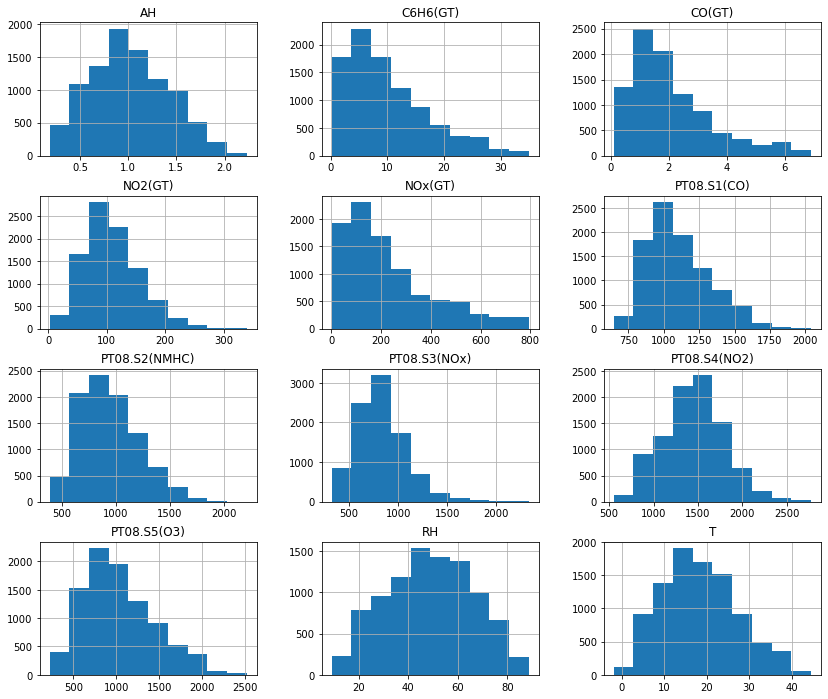

In [18]:
df.hist(figsize=(14,12))

### Visualizing the CO concentration patterns regarding time.

In [19]:
# Create a column with the day of the week names for each date
df['DayofWeek'] = df['Date'].dt.day_name()
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DayofWeek
0,2004-03-10,18:00:00,2.60,1360.00,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,48.88,0.76,Wednesday
1,2004-03-10,19:00:00,2.00,1292.25,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,47.70,0.73,Wednesday
2,2004-03-10,20:00:00,2.20,1402.00,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,53.98,0.75,Wednesday
3,2004-03-10,21:00:00,2.20,1375.50,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,60.00,0.79,Wednesday
4,2004-03-10,22:00:00,1.60,1272.25,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,59.58,0.79,Wednesday


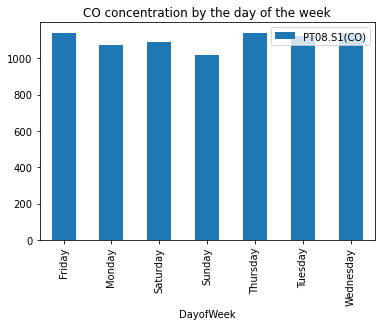

In [20]:
# Print the mean of CO concentration by the day of the week
weekday_grp = df.groupby(['DayofWeek'])
weekday_grp[['Time','PT08.S1(CO)']].mean().plot.bar().set_title('CO concentration by the day of the week')
plt.show()

The concentration of CO on Sunday is reduced compared to the other days of the week as can be seen in the barplot above.<br>
It'll be interesting to see a sequence of the plots for the mean concentration on each day. 

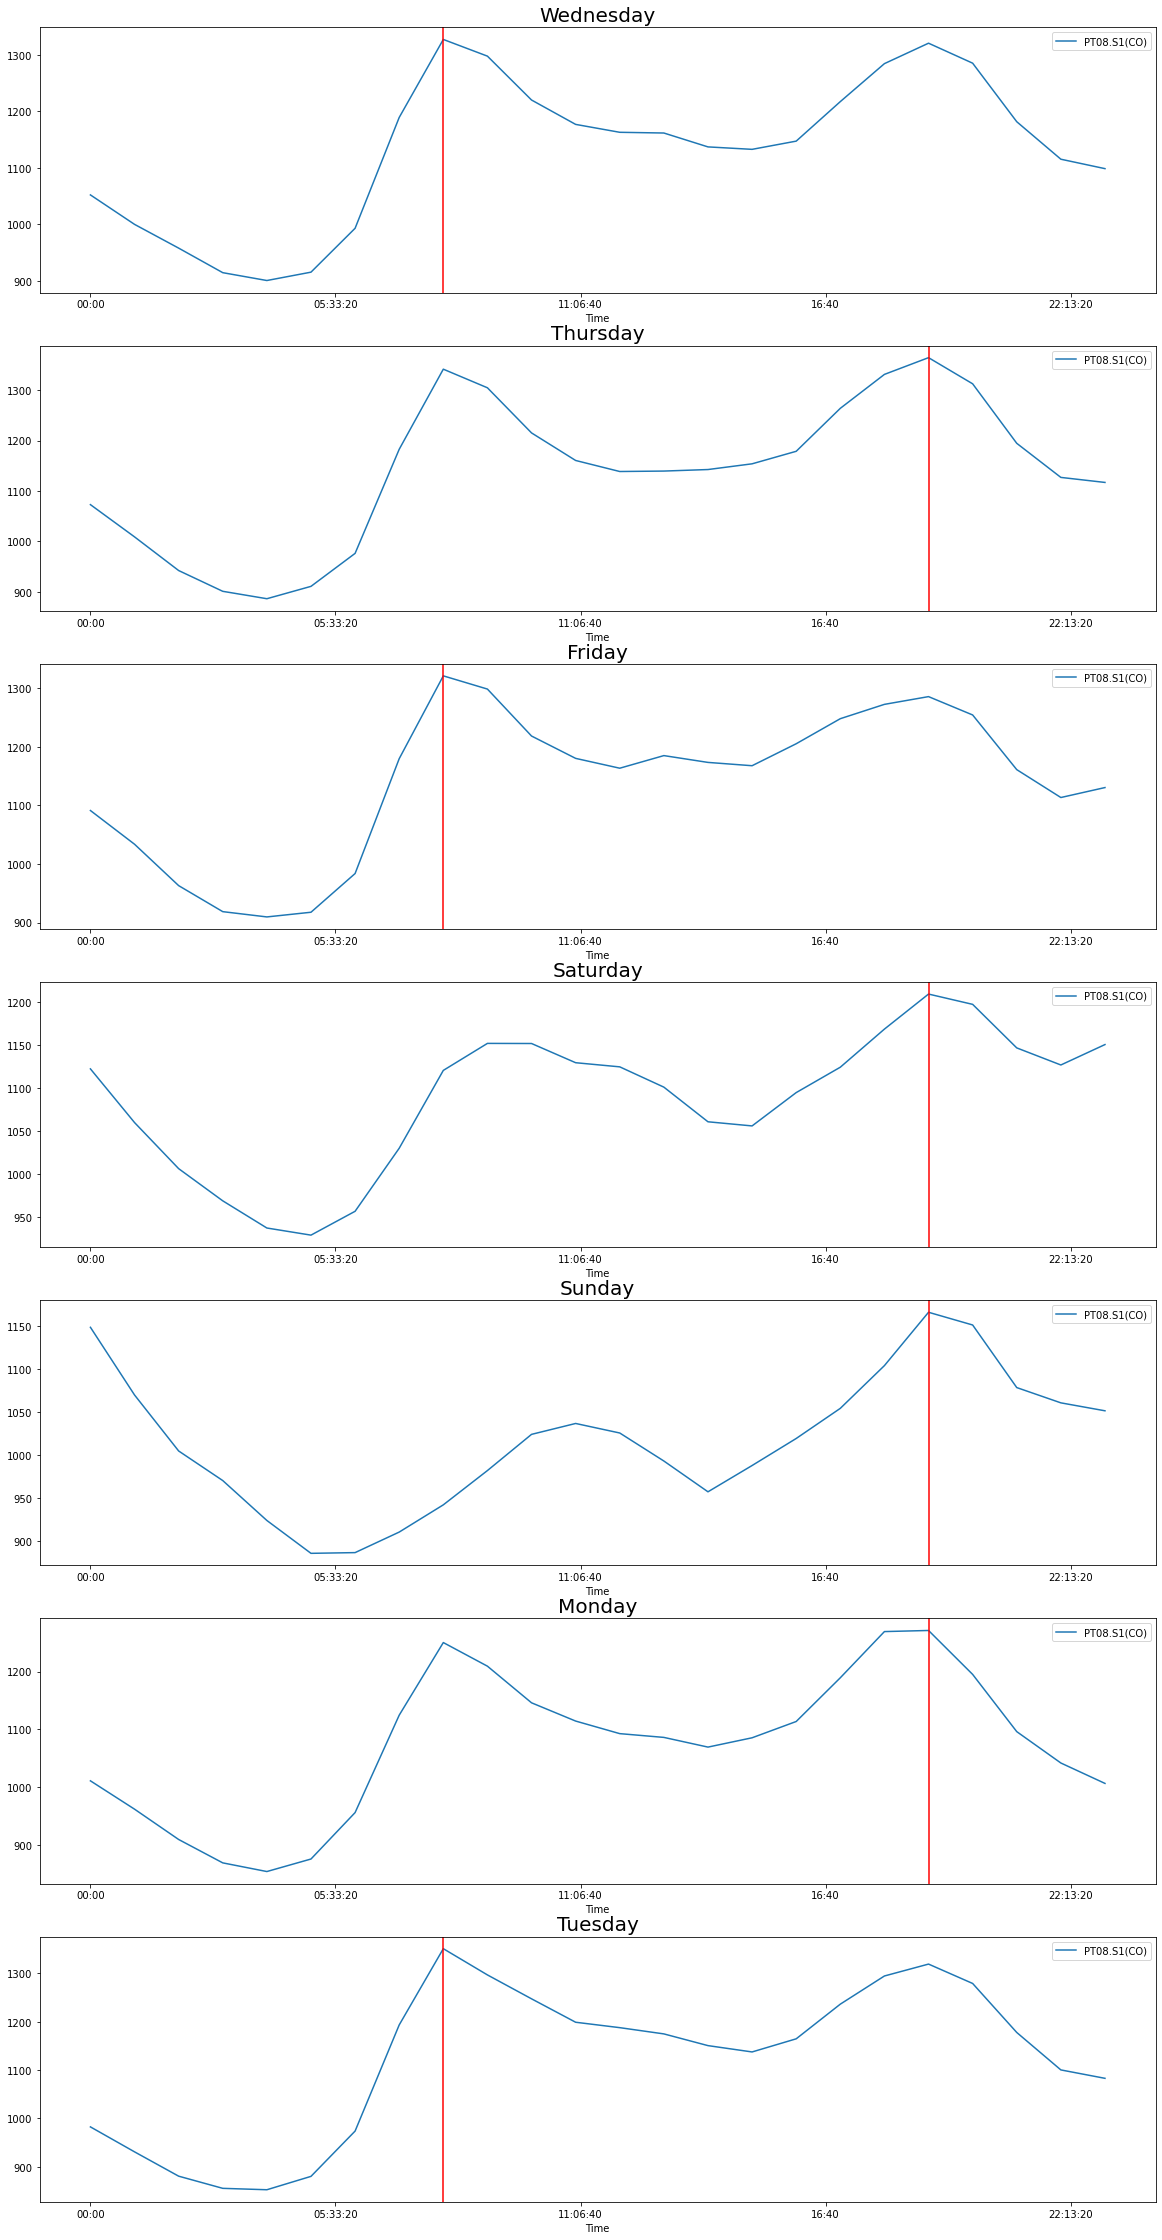

In [21]:
# Plot the mean of CO concentration per weekday
fig, axes = plt.subplots(7, 1, figsize=(20,40))

i=0
for wday in df['DayofWeek'].unique():
    tmp_grp = weekday_grp[['Time','PT08.S1(CO)']].get_group(wday)
    daymean = tmp_grp.groupby('Time')
    daymean.mean().plot(ax=axes[i]).set_title(wday, fontsize=20)
    axes[i].axvline(x=daymean.mean().idxmax()[0], color='red')
    i += 1

On the plots above each day is marked by a vertical red line in its maximum value.<br> 
It's noticeable that everyday has two peaks, one in the morning and the other by the end of afternoon. These correspond with the rush time.<br> 
The graphs for Saturday and Sunday show smaller peaks, especially in the Sunday morning. 

It's also interesting to see how's the concentration of CO along the months.

In [22]:
# Separate data by year-month
df['Month'] = df['Date'].dt.to_period('M')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DayofWeek,Month
0,2004-03-10,18:00:00,2.60,1360.00,11.88,1045.50,166.00,1056.25,113.00,1692.00,1267.50,13.60,48.88,0.76,Wednesday,2004-03
1,2004-03-10,19:00:00,2.00,1292.25,9.40,954.75,103.00,1173.75,92.00,1558.75,972.25,13.30,47.70,0.73,Wednesday,2004-03
2,2004-03-10,20:00:00,2.20,1402.00,9.00,939.25,131.00,1140.00,114.00,1554.50,1074.00,11.90,53.98,0.75,Wednesday,2004-03
3,2004-03-10,21:00:00,2.20,1375.50,9.23,948.25,172.00,1092.00,122.00,1583.75,1203.25,11.00,60.00,0.79,Wednesday,2004-03
4,2004-03-10,22:00:00,1.60,1272.25,6.52,835.50,131.00,1205.00,116.00,1490.00,1110.00,11.15,59.58,0.79,Wednesday,2004-03


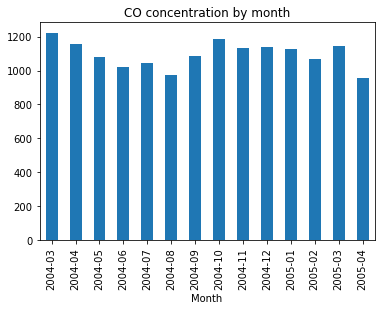

In [23]:
# Print the mean of CO concentration by the month
month_grp = df.groupby(['Month'])
month_grp['PT08.S1(CO)'].mean().plot.bar(sort_columns=True).set_title('CO concentration by month')
plt.show()

A lower concentration of CO is observed on the months June, July and August. These months correspond to the summer holidays.
This is when most people travel and the city becomes less crowded.
<br>
One curious case is April of 2005 which has the lowest CO concentration. It's important to see the plot of the number of samples for each month, as this is the last month of the dataset the samples weren't collected during the whole period.

[]

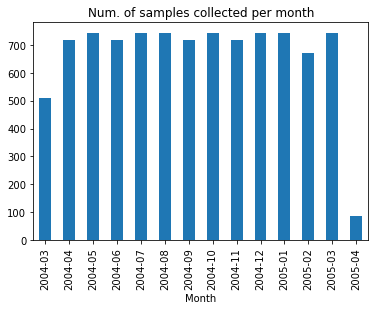

In [24]:
month_grp['PT08.S1(CO)'].count().plot.bar().set_title('Num. of samples collected per month')
plt.plot()

With the plot above it's clear why the concentration of CO in April 2005 was that low, few samples were collected.
<br>
On the other hand it's also interesting that in March 2004 a smaller amount of samples were collecte, comparing to the other months of the same year and it's still he month with the highest concentration of CO. 

In [25]:
# removing temporary columns that won't be used anymore
df.drop(columns=['DayofWeek', 'Month'], inplace=True)

### Feature scaling - Normalizing

The predictor values varie a lot, it'd be helpful for the model to normalize them.
<br>
For that we will use a min-max normalization approach and create a new dataframe.

In [26]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

In [27]:
# we don't normalize the independent and time variables
df_to_normalize = df.drop(columns=['Date', 'Time', 'PT08.S1(CO)']).copy()

In [28]:
scaler = MinMaxScaler() 

In [29]:
df_normalized = pd.DataFrame(scaler.fit_transform(df_to_normalize),
                             columns = df_to_normalize.columns.values)

array([[<AxesSubplot:title={'center':'AH'}>,
        <AxesSubplot:title={'center':'C6H6(GT)'}>,
        <AxesSubplot:title={'center':'CO(GT)'}>],
       [<AxesSubplot:title={'center':'NO2(GT)'}>,
        <AxesSubplot:title={'center':'NOx(GT)'}>,
        <AxesSubplot:title={'center':'PT08.S2(NMHC)'}>],
       [<AxesSubplot:title={'center':'PT08.S3(NOx)'}>,
        <AxesSubplot:title={'center':'PT08.S4(NO2)'}>,
        <AxesSubplot:title={'center':'PT08.S5(O3)'}>],
       [<AxesSubplot:title={'center':'RH'}>,
        <AxesSubplot:title={'center':'T'}>, <AxesSubplot:>]], dtype=object)

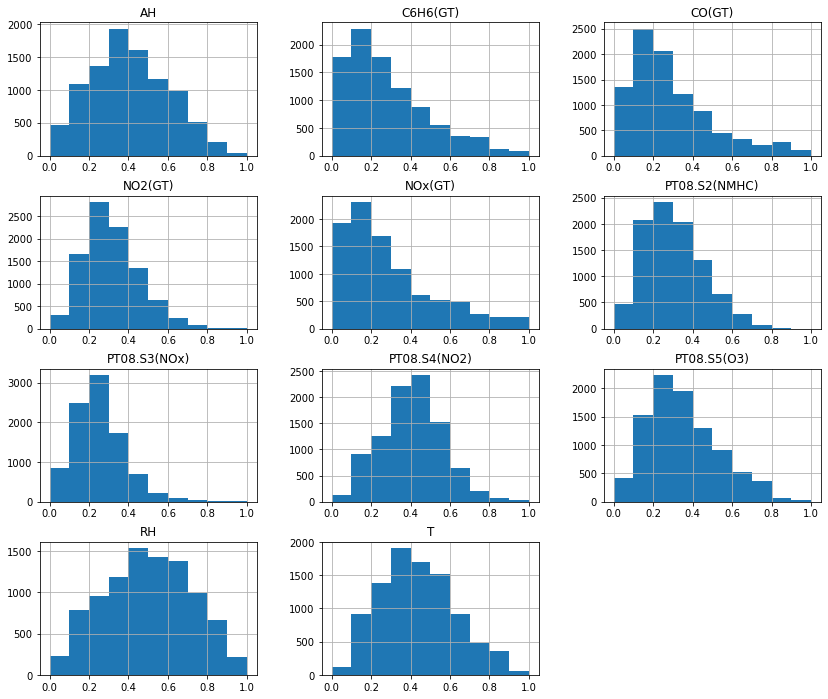

In [30]:
df_normalized.hist(figsize=(14,12))

Then we substitute the predictors for the normalized ones.

In [31]:
# drop from df the normalized columns
df.drop(columns=df_normalized.columns, inplace=True)
# concatenate with the new normalized ones
df = pd.concat([df, df_normalized], axis=1)

# Feature Selection

### Variance threshold

This is a method to remove low-variance features. It's only applied on the dependent variables. [More info]('https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html')
<br>
We'll apply to the normalized dataframe as there we just have the predictors. The default threshold is 0.

In [32]:
var_thres = VarianceThreshold(threshold=(0))

# Fit to data, then transform it.
var_thres.fit(df_normalized)

# Get a mask, or integer index, of the features selected
var_thres.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

As all columns returned `True` it means they all within the threshold and none should be removed. 

### Correlation among predictors

Let's see the pairwise [Pearson correlation]('https://en.wikipedia.org/wiki/Pearson_correlation_coefficient') between all predictors (only numerical predictors can be correlated).

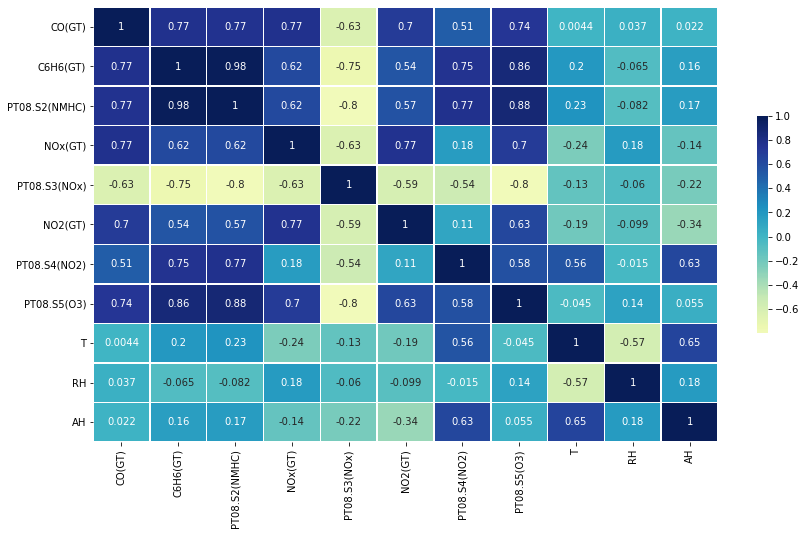

In [33]:
# heatmap of pairwise correlation (Pearson correlation) 
plt.figure(figsize=(14,8))
sns.heatmap(df_normalized.corr(), annot=True, cmap="YlGnBu", center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

The variable that has the highest level of correlation with **PT08.S1(CO)** is **PT08.S5(O3)**. <br>
It's also higly correlated with **PT08.S2(NMHC)** and **C6H6(GT)**.<br> 
<br>
<br>
There are predictors that are higly correlated and we should remove them as they can behave like duplicate predictors. 

In [34]:
# list of numerical predictors (we remove the dependent variable)
list_pred = list(df.select_dtypes(include=['number']).columns)
list_pred.remove('PT08.S1(CO)')

In [35]:
# function to find high correlated predictors
# parameters: dataframe -> pandas dataframe
# parameters: list_pred -> list of predictors within the dataframe you want to calculate
# parameters: threshold -> threshold of the correlation
# return: 2 lists, the first is a list of tuples of predictors with correlations higher than the threshold.
# the second is a list that contains only the first pairwise predictor of the first list.

def corr_threshold(dataframe, list_pred, threshold):
    full_list_corr = []
    one_list_corr = []
    corr_matrix = dataframe[list_pred].corr()
    
    for i in range(len(list_pred)):
        for j in range(i+1, len(list_pred)):
            if np.abs(corr_matrix.iloc[i, j]) >= threshold:
                full_list_corr.append((list_pred[i], list_pred[j]))
                one_list_corr.append(list_pred[i])
                
    return full_list_corr, one_list_corr

In [36]:
full_list_corr, pred_to_drop = corr_threshold(df, list_pred, 0.9)
print('List of predictors pairs above the threshold: \n{}\n'.format(full_list_corr))
print('List of selected predictors above the threshold: \n{}'.format(pred_to_drop))

List of predictors pairs above the threshold: 
[('C6H6(GT)', 'PT08.S2(NMHC)')]

List of selected predictors above the threshold: 
['C6H6(GT)']


Using a threshold of `90%` we just find 2 highly correlated features and we'll remove one of them.

In [37]:
df.drop(columns=pred_to_drop, inplace=True)

Below the correlation list of **PT08.S1(CO)**(our independent variable) in relation to the other ones.

In [38]:
df.corr()['PT08.S1(CO)'].sort_values(ascending=False)

PT08.S1(CO)      1.00
PT08.S5(O3)      0.90
PT08.S2(NMHC)    0.90
CO(GT)           0.76
PT08.S4(NO2)     0.68
NOx(GT)          0.63
NO2(GT)          0.58
AH               0.12
RH               0.12
T                0.04
PT08.S3(NOx)    -0.78
Name: PT08.S1(CO), dtype: float64

KDE (Kernel Density Estimate) plot of **PT08.S1(CO)** and it's highest correlated predictor **PT08.S5(O3)**.

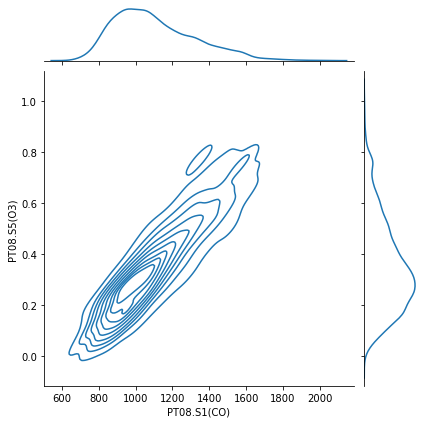

In [39]:
# scatterplot
sns.jointplot(x="PT08.S1(CO)", y="PT08.S5(O3)", kind='kde', data=df)
plt.show()

# Model Building

Before start modeling we prepare our train and test dataset.

In [40]:
# first we drop the date, time and the dependent variable.
X = df.drop(columns=['Date', 'Time', 'PT08.S1(CO)']).copy()

# dependent variable
y = df['PT08.S1(CO)'].copy()

# divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Statistical Modeling

Let's start with a statistical modeling approach to have a baseline.
The Ordinary Least Squares (OLS) regression estimates the difference between the observed and predicted values of the dependent variable configured as a straight line.

In [41]:
# Ordinary Least Squares analysis
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

X_sm = sm.add_constant(X)
model = sm.OLS(y,X_sm)
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            PT08.S1(CO)   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     7209.
Date:                Thu, 01 Apr 2021   Prob (F-statistic):               0.00
Time:                        10:20:14   Log-Likelihood:                -53599.
No. Observations:                9357   AIC:                         1.072e+05
Df Residuals:                    9346   BIC:                         1.073e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           719.6172     10.566     68.105      0.000     698.905     740.330
CO(GT)          121.0999      8.087     14.975      0.000     105.248     136.952
PT08.S2(NMHC)   366.2326     23.425     15.634      0.000     320.315     412.150
NOx(GT)         -55.9758      8.264     -6.773      0.000     -72.175     -39.776
PT08.S3(NOx)   -212.7182     13.034    -16.320      0.000    -238.268    -187.168
NO2(GT)          56.6334     11.271      5.025      0.000      34.541      78.726
PT08.S4(NO2)    359.6222     18.706     19.225      0.000     322.954     396.290
PT08.S5(O3)     449.7575     11.565     38.890      0.000     427.088     472.427
T               -21.8114     15.259     -1.429      0.153     -51.722       8.099
RH              110.5831     10.085     10.965      0.000      90.813     130.353
AH             -150.2814     12.569    -11.957      0.000    -174.919    -125.644
==============================================================================
Omnibus:                      173.961   Durbin-Watson:                   0.171
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              247.066
Skew:                           0.220   Prob(JB):                     2.24e-54
Kurtosis:                       3.663   Cond. No.                         60.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`F-statistic` has a large value of `7209` suggesting that at least one of the variables must be related to our prediction target variable of CO concentration.  
<br>
As the `p-values` of all variables, except for **T**, are smaller than `0.05`, they are all considered statistically significant. It means that there's a strong evidence that for each one of them there's a real association with the concentration of CO **PT08.S1(CO)**. 
<br>
R-squared shows that this model explains `88.5%` of the variation in the CO concentration.<br><br>

### Machine Learning Modeling

To fit a ML model to our dataset we're going to use the [Lazy Predict]('https://pypi.org/project/lazypredict/') package as it allows fitting a lot of scikit-learn models at once and score them by performance.

In [42]:
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:31<00:00,  1.33it/s]


In [43]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.95,0.95,50.27,1.27
HistGradientBoostingRegressor,0.95,0.95,51.17,2.90
RandomForestRegressor,0.95,0.95,51.30,3.30
LGBMRegressor,0.95,0.95,51.31,0.31
XGBRegressor,0.95,0.95,51.78,0.45
KNeighborsRegressor,0.94,0.94,53.20,0.15
BaggingRegressor,0.94,0.94,54.20,0.35
GradientBoostingRegressor,0.93,0.93,60.45,1.45
PoissonRegressor,0.89,0.89,73.96,0.07


Let's select 3 of the best ones from the 42 models, fit again and run cross-validation.

In [44]:
# Extra-trees regression
etr = ExtraTreesRegressor()
etr.fit(X_train, y_train)

print("Extra-trees Regression")
print("-----------------")
print("R2 score (test set): {:.4f}".format(etr.score(X_test, y_test)))

# mean squared error
y_pred_etr = etr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_etr)
print("RMSE: {:.4f}".format(np.sqrt(mse)))

# 10-fold cross validation
etr_cv = np.mean(cross_val_score(etr, X, y, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(etr_cv))

Extra-trees Regression
-----------------
R2 score (test set): 0.9489
RMSE: 50.2708
Mean cross validation 10-fold accuracy: 0.8484


In [45]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print("Random Forest Regressor")
print("-----------------------")
print("R2 score accuracy (test set): {:.4f}".format(rf.score(X_test, y_test)))

# mean squared error
y_pred_rf = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred_rf)
print("RMSE: {:.4f}".format(np.sqrt(mse)))

# 10-fold cross validation
rf_cv = np.mean(cross_val_score(rf, X, y, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(rf_cv))

Random Forest Regressor
-----------------------
R2 score accuracy (test set): 0.9467
RMSE: 51.3597
Mean cross validation 10-fold accuracy: 0.8419


In [46]:
#XGBoost Regressor
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train, y_train)


print("XGBoost Regressor")
print("-----------------")
print("R2 score (test set): {:.4f}".format(xgbr.score(X_test, y_test)))

# mean squared error
y_pred_xgbr = xgbr.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgbr)
print("RMSE: {:.4f}".format(np.sqrt(mse)))

# 10-fold cross validation
xgbr_cv = np.mean(cross_val_score(xgbr, X, y, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(xgbr_cv))

XGBoost Regressor
-----------------
R2 score (test set): 0.9449
RMSE: 52.2289
Mean cross validation 10-fold accuracy: 0.8262


The training dataset was fit using 3 algorithms, Extra-trees Regression, Random Forest Regressor and XGBoost, which are higly interpretable.<br>

The accuracy R-squared and the Root Mean Square Error (RMSE) were calculated on the test datasets. It was also performed a 10-fold cross validation in the full dataset using each model.<br>

Extra-tree Regression was the model that performed better on the dataset compared to the other two. It was followed Random Forest and then XGBoost.

For the sake of making it a bit more visual, below follows a plot of a set of points from the original test dataset and the predicted using Extra-trees Regression (the best fit for this dataset).

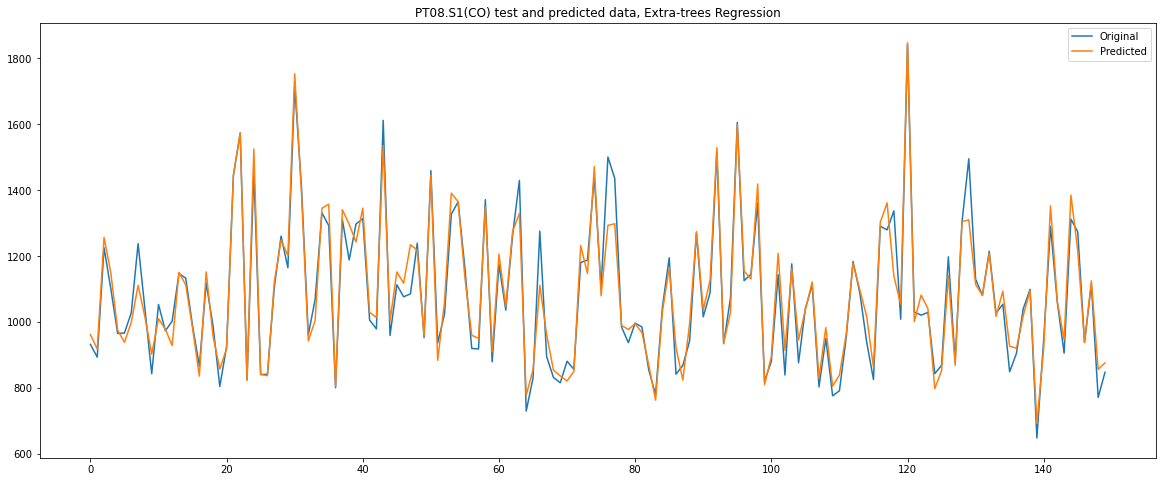

In [47]:
size_plt = 150 # size of the dataset to plot

plt.figure(figsize=(20,8))
x_ax = range(len(y_test[:size_plt]))
plt.plot(x_ax, y_test[:size_plt], label="Original")
plt.plot(x_ax, y_pred_etr[:size_plt], label="Predicted")
plt.title("PT08.S1(CO) test and predicted data, Extra-trees Regression")
plt.legend()
plt.show()

### Tuning parameters of a model
As XGBoost is quite powerful and offers some interesting options it will pass through a process of parameter tuning.<br><br>
Instead of using gridsearch, excellent but slow, we'll make an experiment with [Optuna]('https://optuna.org/'). Optuna turns out to be an agnostic and automatic parameter search. <br>
Some parameters, to be tuned, were chosen from the list of [parameters of XGBoost]('https://xgboost.readthedocs.io/en/latest/parameter.html') to plug in optuna.
<br><br>
Bellow the list of current parameters of the model used to fit the data.

In [48]:
# parameters of the current model
xgbr.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0}

In [49]:
# objective function to be used by optuna study
def objective(trial):
    
    x_max_depth = trial.suggest_int('max_depth', 3, 10)
    x_learning_rate = trial.suggest_uniform('learning_rate', 0.1, 1)
    x_gamma = trial.suggest_categorical('gamma', [0, 0.25, 0.5, 1.0])
    x_reg_lambda = trial.suggest_categorical('lambda', [0, 1, 5, 10, 20, 100])
    x_scale_pos_weight = trial.suggest_categorical('scale_pos_weight', [1, 3, 5])
    
    classifier_obj = xgb.XGBRegressor(verbosity=0, 
                                      max_depth=x_max_depth,
                                      learning_rate=x_learning_rate,
                                      gamma=x_gamma,
                                      reg_lambda=x_reg_lambda,
                                      scale_pos_weight=x_scale_pos_weight) 
    
    
    classifier_obj.fit(X_train, y_train)
    

    score = np.mean(cross_val_score(classifier_obj, X_train, y_train, cv=10))
    accuracy = score.mean()
    return accuracy

In [50]:
study = optuna.create_study(direction="maximize") # maximize the cross_val_score
study.optimize(objective, n_trials=100)
print(study.best_trial)

[I 2021-04-01 10:21:54,913] A new study created in memory with name: no-name-87204922-dcd2-424d-95f6-51d3bfe37f24
[I 2021-04-01 10:21:57,697] Trial 0 finished with value: 0.942348093655623 and parameters: {'max_depth': 6, 'learning_rate': 0.5943881729103881, 'gamma': 0.25, 'lambda': 100, 'scale_pos_weight': 1}. Best is trial 0 with value: 0.942348093655623.
[I 2021-04-01 10:22:00,282] Trial 1 finished with value: 0.9456370241520272 and parameters: {'max_depth': 6, 'learning_rate': 0.31877785081264864, 'gamma': 0.25, 'lambda': 20, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.9456370241520272.
[I 2021-04-01 10:22:02,958] Trial 2 finished with value: 0.9368301028766528 and parameters: {'max_depth': 5, 'learning_rate': 0.9744920047517007, 'gamma': 0.25, 'lambda': 100, 'scale_pos_weight': 1}. Best is trial 1 with value: 0.9456370241520272.
[I 2021-04-01 10:22:06,438] Trial 3 finished with value: 0.9464071822140377 and parameters: {'max_depth': 7, 'learning_rate': 0.3465463653892558

[I 2021-04-01 10:24:28,445] Trial 32 finished with value: 0.9495909625782881 and parameters: {'max_depth': 10, 'learning_rate': 0.11658296005880166, 'gamma': 0, 'lambda': 5, 'scale_pos_weight': 5}. Best is trial 10 with value: 0.9510284327162484.
[I 2021-04-01 10:24:36,942] Trial 33 finished with value: 0.9494185897945491 and parameters: {'max_depth': 9, 'learning_rate': 0.10689546436664372, 'gamma': 0.25, 'lambda': 5, 'scale_pos_weight': 1}. Best is trial 10 with value: 0.9510284327162484.
[I 2021-04-01 10:24:43,731] Trial 34 finished with value: 0.9413957146835228 and parameters: {'max_depth': 10, 'learning_rate': 0.26633369310832283, 'gamma': 0, 'lambda': 0, 'scale_pos_weight': 5}. Best is trial 10 with value: 0.9510284327162484.
[I 2021-04-01 10:24:45,990] Trial 35 finished with value: 0.9388401941469505 and parameters: {'max_depth': 4, 'learning_rate': 0.16714023413594817, 'gamma': 0.25, 'lambda': 5, 'scale_pos_weight': 5}. Best is trial 10 with value: 0.9510284327162484.
[I 2021-

[I 2021-04-01 10:27:29,253] Trial 64 finished with value: 0.950781450184731 and parameters: {'max_depth': 10, 'learning_rate': 0.12414252193399095, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 62 with value: 0.9516922595253942.
[I 2021-04-01 10:27:35,605] Trial 65 finished with value: 0.9499674171485266 and parameters: {'max_depth': 10, 'learning_rate': 0.1255867230155289, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 62 with value: 0.9516922595253942.
[I 2021-04-01 10:27:42,849] Trial 66 finished with value: 0.94908094992978 and parameters: {'max_depth': 10, 'learning_rate': 0.19045455979009418, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 62 with value: 0.9516922595253942.
[I 2021-04-01 10:27:50,185] Trial 67 finished with value: 0.950233695689527 and parameters: {'max_depth': 10, 'learning_rate': 0.16158692189124457, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 62 with value: 0.9516922595253942.
[I 2021-04-01 10:

[I 2021-04-01 10:30:42,922] Trial 96 finished with value: 0.9493394284944815 and parameters: {'max_depth': 10, 'learning_rate': 0.1725903162093021, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 82 with value: 0.9517430975369088.
[I 2021-04-01 10:30:47,967] Trial 97 finished with value: 0.9502690849076698 and parameters: {'max_depth': 9, 'learning_rate': 0.10345417766518161, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 82 with value: 0.9517430975369088.
[I 2021-04-01 10:30:53,616] Trial 98 finished with value: 0.9494305488070808 and parameters: {'max_depth': 9, 'learning_rate': 0.14172356763338692, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}. Best is trial 82 with value: 0.9517430975369088.
[I 2021-04-01 10:30:59,216] Trial 99 finished with value: 0.9100227362710568 and parameters: {'max_depth': 10, 'learning_rate': 0.7881982470066242, 'gamma': 0.5, 'lambda': 1, 'scale_pos_weight': 1}. Best is trial 82 with value: 0.9517430975369088.


FrozenTrial(number=82, values=[0.9517430975369088], datetime_start=datetime.datetime(2021, 4, 1, 10, 29, 8, 169369), datetime_complete=datetime.datetime(2021, 4, 1, 10, 29, 15, 124326), params={'max_depth': 10, 'learning_rate': 0.1253020148907814, 'gamma': 0, 'lambda': 1, 'scale_pos_weight': 5}, distributions={'max_depth': IntUniformDistribution(high=10, low=3, step=1), 'learning_rate': UniformDistribution(high=1.0, low=0.1), 'gamma': CategoricalDistribution(choices=(0, 0.25, 0.5, 1.0)), 'lambda': CategoricalDistribution(choices=(0, 1, 5, 10, 20, 100)), 'scale_pos_weight': CategoricalDistribution(choices=(1, 3, 5))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=82, state=TrialState.COMPLETE, value=None)


Optuna found better parameters for XGBoost by optimizing the cross validation score.<br> 
The same model of before will be tested with the new parameters found.

In [51]:
#XGBoost Regressor
xgbr_t = xgb.XGBRegressor(verbosity=0,
                       max_depth=10,
                       learning_rate=0.1253020148907814,
                       gamma=0,
                       lamda=1,
                       scale_pos_weight=5) 
xgbr_t.fit(X_train, y_train)

print("XGBoost Regressor tuned")
print("-----------------------")
print("R2 score (test set): {:.4f}".format(xgbr_t.score(X_test, y_test)))

# mean squared error
y_pred_xgbr = xgbr_t.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgbr)
print("RMSE: {:.4f}".format(np.sqrt(mse)))

# 10-fold cross validation
xgbr_cv = np.mean(cross_val_score(xgbr_t, X, y, cv=10))
print("Mean cross validation 10-fold accuracy: {:.4f}".format(xgbr_cv))

XGBoost Regressor tuned
-----------------------
R2 score (test set): 0.9499
RMSE: 49.7940
Mean cross validation 10-fold accuracy: 0.8389


The new parameters gave the xgboost model a better fit over the train and test datasets.<br><br>
XGBoost also has the advantage of a graph displaying the importance of each feature for the trained model.

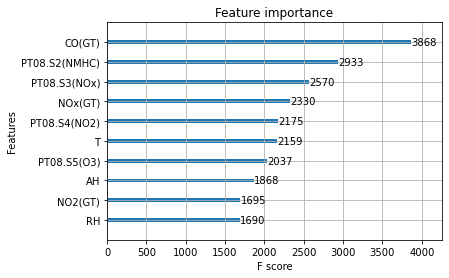

In [52]:
xgb.plot_importance(xgbr_t) 
plt.show()

---
---

In [53]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Thu Apr 01 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pandas     : 1.0.5
matplotlib : 3.3.2
seaborn    : 0.11.0
xgboost    : 1.1.1
numpy      : 1.19.1
lazypredict: 0.2.9
optuna     : 2.6.0
statsmodels: 0.12.0

Watermark: 2.1.0

